In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

In [3]:
phase_data_full = pd.read_csv('./Phase_Calc_Data.csv')
phase_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47412 entries, 0 to 47411
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   el0           47412 non-null  object 
 1   el1           47412 non-null  object 
 2   el2           47412 non-null  object 
 3   el3           47412 non-null  object 
 4   x0            47412 non-null  float64
 5   x1            47412 non-null  float64
 6   x2            47412 non-null  float64
 7   x3            47412 non-null  float64
 8   phase_1_name  47412 non-null  object 
 9   phase_2_name  19198 non-null  object 
 10  phase_3_name  4822 non-null   object 
 11  phase_4_name  585 non-null    object 
 12  phase_5_name  3 non-null      object 
 13  phase_1_frac  47412 non-null  float64
 14  phase_2_frac  19198 non-null  float64
 15  phase_3_frac  4822 non-null   float64
 16  phase_4_frac  585 non-null    float64
 17  phase_5_frac  3 non-null      float64
dtypes: float64(9), object(9)
m

C:\Users\Mathias\Anaconda3\envs\ml_tf\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Cleaning/Transformations

### Cleaning the Data:
There are a few attributes of the dataset that aren't particularly relevant/useful, and those are the phase_x_fracs. It doesn't really matter how much of each phase is present, when all I really care about is which phases are present. Also, not all combinations of elements yield 3, 4, or 5 phases in equilibrium, so those need to be filled in wth 'none'.

### Transforming the Data: 
I plan to have each node in the input layer of my neural network correspond to the amount of one of the 10 possible elements that show up in the dataset. Some Pandas magic needs to happen so that the column elements are reformatted to fit the above description. 

Once the dataset is all nice and formatted, the dataset is split into a train set and test set. These are turned into more tensorflow friendly formats using from_tensor_slices() from tf.data.Dataset, before finally getting batched. 

In [4]:
# Class definitions for data cleaning pipeline

class dropAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, drop_phase_fracs = True): # no *args or **kwargs
        self.drop_phase_fracs = drop_phase_fracs
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        if self.drop_phase_fracs:
            X.drop(X.iloc[:, 13:18], inplace = True, axis = 1) #drop all phase_{x}_frac
            return X
        else:
            return X
        
class cleanupNan(BaseEstimator, TransformerMixin):
    def __init__(self, dropped_phase_fracs = True):
        self.dropped_phase_fracs = dropped_phase_fracs
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.fillna('none', inplace = True)
        return X

In [5]:
# The lists of columns that will be used for ColumnTransformer
all_attribs = list(phase_data_full)
feature_attribs = ['el0', 'el1', 'el2', 'el3']
label_attribs = ['phase_1_name', 'phase_2_name', 'phase_3_name', 'phase_4_name', 'phase_5_name']

# Get the unique feature categories
unique_features_list = pd.unique(phase_data_full[feature_attribs].values.ravel('K')).tolist()
print('Elements list:', unique_features_list)

# Get the unique labels for LabelBinarizer()
unique_labels = pd.unique(phase_data_full[label_attribs].values.ravel('K'))
unique_labels_list = unique_labels.tolist()
cleaned_unique_labels_list = [x for x in unique_labels_list if x == x]
print('Features list:', cleaned_unique_labels_list)
      
clean_pipeline = Pipeline([
    ('dropper', dropAttributes()),
    ('cleaner', cleanupNan()),
])

phase_data_clean = clean_pipeline.fit_transform(phase_data_full)
phase_data_clean.head(5)

Elements list: ['AL', 'FE', 'MN', 'NB', 'NI', 'TA', 'V', 'MO', 'CR', 'TI']
Features list: ['LIQUID', 'AL3M_D022', 'AL2TI', 'ALTI', 'ALM_D019', 'HCP_A3', 'AL11CR2', 'BCC_B2', 'AL9CR4_L', 'AL8CR5_L', 'ALCR2', 'AL4CR', 'CUB_A15', 'AL4MO', 'AL8MO3', 'FCC_A1', 'LAVES_C15', 'LAVES_C14', 'FETI', 'AL2FE', 'AL5FE2', 'AL13FE4', 'AL5MO', 'CR3SI_A15', 'SIGMA', 'CUB_A13', 'CBCC_A12', 'CR3MN5', 'AL8MN5_D810', 'AL11MN4', 'AL4MN', 'CRSI2', 'AL6MN', 'ALPHA_TIMN', 'AL3TA2_L', 'NI2V', 'NI3V', 'NI2V7', 'AL13CR2']


,el0,el1,el2,el3,x0,x1,x2,x3,phase_1_name,phase_2_name,phase_3_name,phase_4_name,phase_5_name
0,AL,MO,CR,TI,0.9,0.0,0.0,0.1,LIQUID,AL3M_D022,none,none,none
1,AL,MO,CR,TI,0.8,0.0,0.0,0.2,LIQUID,AL3M_D022,none,none,none
2,AL,MO,CR,TI,0.7,0.0,0.0,0.3,AL3M_D022,AL2TI,none,none,none
3,AL,MO,CR,TI,0.6,0.0,0.0,0.4,AL2TI,ALTI,none,none,none
4,AL,MO,CR,TI,0.5,0.0,0.0,0.5,ALTI,none,none,none,none


In [6]:
data_copy = phase_data_clean.copy()

In [7]:
#Rearrange dataframe to be more compatible with models.
base_df = data_copy.iloc[:, 0:8] #the columns el0 to x3
rearranged_features = pd.wide_to_long(base_df.reset_index(), ['el', 'x'], 'index', 'No')\
.reset_index(level=1, drop=True)\
.set_index('el', append=True)['x']\
.unstack()\
.fillna(0.0)

In [8]:
phase_label_data = data_copy[label_attribs].copy()
unique_labels = pd.unique(phase_label_data[label_attribs].values.ravel('K')).tolist()
cleaned_unique_labels = [x for x in unique_labels if x == x] #take advantage of fact that nan == nan evals to false

# Fit label binarizer to the phase names
lb = LabelBinarizer()
lb.fit(cleaned_unique_labels)
lb.classes_

array(['AL11CR2', 'AL11MN4', 'AL13CR2', 'AL13FE4', 'AL2FE', 'AL2TI',
       'AL3M_D022', 'AL3TA2_L', 'AL4CR', 'AL4MN', 'AL4MO', 'AL5FE2',
       'AL5MO', 'AL6MN', 'AL8CR5_L', 'AL8MN5_D810', 'AL8MO3', 'AL9CR4_L',
       'ALCR2', 'ALM_D019', 'ALPHA_TIMN', 'ALTI', 'BCC_B2', 'CBCC_A12',
       'CR3MN5', 'CR3SI_A15', 'CRSI2', 'CUB_A13', 'CUB_A15', 'FCC_A1',
       'FETI', 'HCP_A3', 'LAVES_C14', 'LAVES_C15', 'LIQUID', 'NI2V',
       'NI2V7', 'NI3V', 'SIGMA', 'none'], dtype='<U11')

In [9]:
phase_1_data = phase_label_data['phase_1_name']
phase_1_data.columns = 'phase1'

phase_2_data = phase_label_data['phase_2_name']
phase_2_data.columns = 'phase2'

phase_3_data = phase_label_data['phase_3_name']
phase_3_data.columns = 'phase3'

phase_4_data = phase_label_data['phase_4_name']
phase_4_data.columns = 'phase4'

phase_5_data = phase_label_data['phase_5_name']
phase_5_data.columns = 'phase5'
    
def binarizer(label_data):
    binarized_data = lb.transform(label_data)
    df_binarized_labels = pd.DataFrame(binarized_data, columns=[lb.classes_])
    return pd.concat([label_data, df_binarized_labels], axis = 1)

phase_1_data_enc = binarizer(phase_1_data)
phase_2_data_enc = binarizer(phase_2_data)
phase_3_data_enc = binarizer(phase_3_data)
phase_4_data_enc = binarizer(phase_4_data)
phase_5_data_enc = binarizer(phase_5_data)

full_encoded_labels = phase_1_data_enc + phase_2_data_enc + phase_3_data_enc + phase_4_data_enc + phase_5_data_enc

full_encoded_labels = full_encoded_labels.drop(['phase_1_name', 'phase_2_name', 'phase_3_name', 'phase_4_name', 'phase_5_name'], axis = 1)

In [10]:
# There's no point in anything being greater than 1 to indicate the presence of a phase
full_encoded_labels[full_encoded_labels != 0] = 1 

In [11]:
workable_dataset = pd.concat([rearranged_features, full_encoded_labels], axis = 1)
workable_dataset = workable_dataset.iloc[:, :-1]#no need for the 'none,' column, which is leftover from the encoding when there isn't a 4th or 5th phase
workable_dataset.head(2)

,AL,CR,FE,MN,MO,NB,NI,TA,TI,V,...,"(FCC_A1,)","(FETI,)","(HCP_A3,)","(LAVES_C14,)","(LAVES_C15,)","(LIQUID,)","(NI2V,)","(NI2V7,)","(NI3V,)","(SIGMA,)"
0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
train_set, test_set = train_test_split(workable_dataset, test_size = 0.2, random_state=42)
X_train_set = train_set.iloc[:, 0:10]
y_train_set = train_set.iloc[:, 10:49]

In [13]:
full_dataset = tf.data.Dataset.from_tensor_slices((X_train_set.values, y_train_set.values))

In [14]:
full_dataset

<TensorSliceDataset shapes: ((10,), (39,)), types: (tf.float64, tf.int32)>

In [15]:
batched_dataset = full_dataset.batch(5000)
batched_dataset

<BatchDataset shapes: ((None, 10), (None, 39)), types: (tf.float64, tf.int32)>

## Training the Neural Network
Considering how bare-bones this dataset is I would be pretty impressed to get accuracies above 70%. Phase stability calculations usually take into account a lot more information than just the amount of each element available. The CALPHAD (CALculation of PHAse Diagrams) methodology uses literally all thermodynamic and kinetic information available to produce a phase diagram of multicomponent alloy systems. Meanwhile I just know the elements and their respective amounts in my hypothetical multicomponent system.  

In [17]:
# NN with 1 hidden layer with 100 neurons

def get_1layer_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, input_dim=10, activation='relu'),
    tf.keras.layers.Dense(39, activation='sigmoid'),
  ])

  model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
  return model

In [18]:
model = get_1layer_model()
history = model.fit(batched_dataset, epochs = 80)

Epoch 1/80
8/8 [==============================] - 2s 39ms/step - loss: 0.6992 - accuracy: 0.0120
Epoch 2/80
8/8 [==============================] - 0s 33ms/step - loss: 0.6983 - accuracy: 0.0120
Epoch 3/80
8/8 [==============================] - 0s 32ms/step - loss: 0.6974 - accuracy: 0.0119
Epoch 4/80
8/8 [==============================] - 0s 31ms/step - loss: 0.6965 - accuracy: 0.0119
Epoch 5/80
8/8 [==============================] - 0s 31ms/step - loss: 0.6956 - accuracy: 0.0119
Epoch 6/80
8/8 [==============================] - 0s 32ms/step - loss: 0.6947 - accuracy: 0.0119
Epoch 7/80
8/8 [==============================] - 0s 33ms/step - loss: 0.6938 - accuracy: 0.0118
Epoch 8/80
8/8 [==============================] - 0s 32ms/step - loss: 0.6929 - accuracy: 0.0119
Epoch 9/80
8/8 [==============================] - 0s 34ms/step - loss: 0.6921 - accuracy: 0.0123
Epoch 10/80
8/8 [==============================] - 0s 40ms/step - loss: 0.6912 - accuracy: 0.0120 0s - loss: 0.6912 - accuracy:

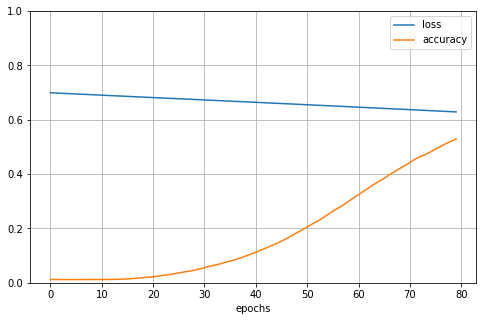

In [19]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1) #setting vertical range from 0-1.0
plt.xlabel('epochs')
plt.show()

In [20]:
X_test = test_set.iloc[:,0:10]
y_test = test_set.iloc[:,10:50]
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(5000)
model.evaluate(test_dataset)

2/2 [==============================] - 0s 22ms/step - loss: 0.6282 - accuracy: 0.5317


[0.6282374858856201, 0.5316882729530334]

In [21]:
# NN with 2 hidden layers, the first with 100 neurons and the second with 200 neurons

def get_2layer_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(100, input_dim=10, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(39, activation='sigmoid')
    ])
    
    model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
    return model

In [22]:
model2 = get_2layer_model()
history2 = model.fit(batched_dataset, epochs = 80)

Epoch 1/80
8/8 [==============================] - 0s 33ms/step - loss: 0.6278 - accuracy: 0.5366
Epoch 2/80
8/8 [==============================] - 0s 34ms/step - loss: 0.6268 - accuracy: 0.5453
Epoch 3/80
8/8 [==============================] - 0s 34ms/step - loss: 0.6259 - accuracy: 0.5535
Epoch 4/80
8/8 [==============================] - 0s 31ms/step - loss: 0.6250 - accuracy: 0.5610
Epoch 5/80
8/8 [==============================] - 0s 34ms/step - loss: 0.6240 - accuracy: 0.5688
Epoch 6/80
8/8 [==============================] - 0s 33ms/step - loss: 0.6231 - accuracy: 0.5759
Epoch 7/80
8/8 [==============================] - 0s 36ms/step - loss: 0.6221 - accuracy: 0.5825
Epoch 8/80
8/8 [==============================] - 0s 34ms/step - loss: 0.6212 - accuracy: 0.5885
Epoch 9/80
8/8 [==============================] - 0s 32ms/step - loss: 0.6202 - accuracy: 0.5964 0s - loss: 0.6204 - accuracy: 0.
Epoch 10/80
8/8 [==============================] - 0s 34ms/step - loss: 0.6193 - accuracy: 0.6

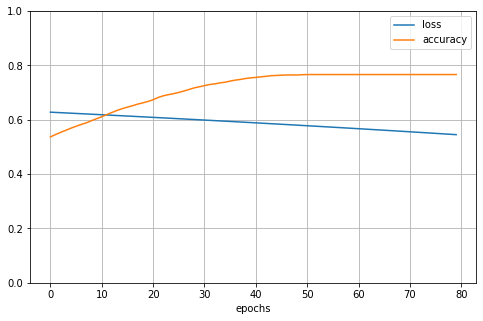

In [23]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1) #setting vertical range from 0-1.0
plt.xlabel('epochs')
plt.show()

In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(5000)
model.evaluate(test_dataset)

2/2 [==============================] - 0s 33ms/step - loss: 0.5444 - accuracy: 0.7702


[0.5443642735481262, 0.7702203989028931]

## Hyperparameter Tuning

Instead of spending all day guessing and testing the right hyperparameters, I can have sklearn explore the hyperparameter space (guess and test) for me. To do this, I wrap the Keras models in objects that emulate sklearn regressors. First, I create a build_model() function that builds and compiles a Keras model with a given set of hyperparameters. Second, I create a KerasRegressor based on the build_model() function. The KerasRegressor object is an implementation of the sklearn regressor API for Keras, which allows you to call fit()/score()/predict(), all the fun stuff you'd expect. Lastly, a randomized search (too many hyperparameters for grid search) is used to explore the hyperparameter space that includes the number of hidden layers, number of neurons, and the learning rate. 

In [47]:
# Function to build and compile a Keras model
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(10,)))
    for layer in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(39, activation='sigmoid'))
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [48]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [49]:
# Just make sure this works like it's supposed to
keras_reg.fit(X_train_set.values, y_train_set.values, epochs=5)

Epoch 1/5
1186/1186 [==============================] - 1s 716us/step - loss: 0.6848 - accuracy: 0.0351
Epoch 2/5
1186/1186 [==============================] - 1s 705us/step - loss: 0.6535 - accuracy: 0.0468
Epoch 3/5
1186/1186 [==============================] - 1s 688us/step - loss: 0.6237 - accuracy: 0.1310
Epoch 4/5
1186/1186 [==============================] - 1s 697us/step - loss: 0.5925 - accuracy: 0.3553
Epoch 5/5
1186/1186 [==============================] - 1s 708us/step - loss: 0.5573 - accuracy: 0.5547


In [50]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(20,200),
    "learning_rate": np.logspace(10**-5, 10)
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_set.values, y_train_set.values, epochs=100, callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/100
791/791 [==============================] - 1s 730us/step - loss: 0.0459 - accuracy: 0.7604
Epoch 2/100
791/791 [==============================] - 1s 738us/step - loss: 0.0419 - accuracy: 0.7617
Epoch 3/100
791/791 [==============================] - 1s 713us/step - loss: 0.0413 - accuracy: 0.7606
Epoch 4/100
791/791 [==============================] - 1s 700us/step - loss: 0.0412 - accuracy: 0.7607
Epoch 5/100
791/791 [==============================] - 1s 716us/step - loss: 0.0411 - accuracy: 0.7608
Epoch 6/100
791/791 [==============================] - 1s 704us/step - loss: 0.0410 - accuracy: 0.7608
Epoch 7/100
791/791 [==============================] - 1s 706us/step - loss: 0.0408 - accuracy: 0.7615
Epoch 8/100
791/791 [==============================] - 1s 690us/step - loss: 0.0408 - accuracy: 0.7620
Epoch 9/100
791/791 [==============================] - 1s 712us/step - loss: 0.0407 - accuracy: 0.7606
Epoch 10/100
791/791 [==============================] - 1s 761us/step - l

791/791 [==============================] - 0s 631us/step - loss: 0.0403 - accuracy: 0.7623
Epoch 72/100
791/791 [==============================] - 1s 669us/step - loss: 0.0403 - accuracy: 0.7616
Epoch 73/100
791/791 [==============================] - 1s 682us/step - loss: 0.0404 - accuracy: 0.7618
Epoch 74/100
791/791 [==============================] - 1s 727us/step - loss: 0.0404 - accuracy: 0.7608
Epoch 75/100
791/791 [==============================] - 1s 641us/step - loss: 0.0403 - accuracy: 0.7622
Epoch 76/100
791/791 [==============================] - 1s 652us/step - loss: 0.0403 - accuracy: 0.7614
Epoch 77/100
791/791 [==============================] - 1s 648us/step - loss: 0.0403 - accuracy: 0.7614
Epoch 78/100
791/791 [==============================] - 1s 632us/step - loss: 0.0403 - accuracy: 0.7607
Epoch 79/100
791/791 [==============================] - 0s 623us/step - loss: 0.0403 - accuracy: 0.7616
Epoch 80/100
791/791 [==============================] - 0s 618us/step - loss:

Epoch 6/100
791/791 [==============================] - 1s 720us/step - loss: 0.0407 - accuracy: 0.7638
Epoch 7/100
791/791 [==============================] - 1s 711us/step - loss: 0.0406 - accuracy: 0.7598
Epoch 8/100
791/791 [==============================] - 1s 717us/step - loss: 0.0405 - accuracy: 0.7624
Epoch 9/100
791/791 [==============================] - 1s 789us/step - loss: 0.0406 - accuracy: 0.7613
Epoch 10/100
791/791 [==============================] - 1s 767us/step - loss: 0.0404 - accuracy: 0.7609
Epoch 11/100
791/791 [==============================] - 1s 749us/step - loss: 0.0406 - accuracy: 0.7616
Epoch 12/100
791/791 [==============================] - 1s 744us/step - loss: 0.0404 - accuracy: 0.7624
Epoch 13/100
791/791 [==============================] - 1s 717us/step - loss: 0.0404 - accuracy: 0.7628
Epoch 14/100
791/791 [==============================] - 1s 675us/step - loss: 0.0404 - accuracy: 0.7611
Epoch 15/100
791/791 [==============================] - 1s 699us/ste

791/791 [==============================] - 1s 718us/step - loss: 0.0400 - accuracy: 0.7612
Epoch 77/100
791/791 [==============================] - 1s 718us/step - loss: 0.0400 - accuracy: 0.7624
Epoch 78/100
791/791 [==============================] - 1s 800us/step - loss: 0.0400 - accuracy: 0.7612
Epoch 79/100
791/791 [==============================] - 1s 776us/step - loss: 0.0401 - accuracy: 0.7623
Epoch 80/100
791/791 [==============================] - 1s 724us/step - loss: 0.0400 - accuracy: 0.7616
Epoch 81/100
791/791 [==============================] - 1s 727us/step - loss: 0.0401 - accuracy: 0.7626
Epoch 82/100
791/791 [==============================] - 1s 704us/step - loss: 0.0398 - accuracy: 0.7618
Epoch 83/100
791/791 [==============================] - 1s 699us/step - loss: 0.0400 - accuracy: 0.7619
Epoch 84/100
791/791 [==============================] - 1s 693us/step - loss: 0.0400 - accuracy: 0.7612
Epoch 85/100
791/791 [==============================] - 1s 707us/step - loss:

Epoch 11/100
791/791 [==============================] - 1s 685us/step - loss: 0.0405 - accuracy: 0.7611
Epoch 12/100
791/791 [==============================] - 1s 679us/step - loss: 0.0404 - accuracy: 0.7608
Epoch 13/100
791/791 [==============================] - 1s 734us/step - loss: 0.0405 - accuracy: 0.7626
Epoch 14/100
791/791 [==============================] - 1s 704us/step - loss: 0.0403 - accuracy: 0.7610
Epoch 15/100
791/791 [==============================] - 1s 693us/step - loss: 0.0404 - accuracy: 0.7603
Epoch 16/100
791/791 [==============================] - 1s 679us/step - loss: 0.0404 - accuracy: 0.7603
Epoch 17/100
791/791 [==============================] - 1s 691us/step - loss: 0.0404 - accuracy: 0.7613
Epoch 18/100
791/791 [==============================] - 1s 686us/step - loss: 0.0403 - accuracy: 0.7607
Epoch 19/100
791/791 [==============================] - 1s 702us/step - loss: 0.0403 - accuracy: 0.7609
Epoch 20/100
791/791 [==============================] - 1s 760us

791/791 [==============================] - 1s 921us/step - loss: 0.0401 - accuracy: 0.7615
Epoch 82/100
791/791 [==============================] - 1s 934us/step - loss: 0.0401 - accuracy: 0.7612
Epoch 83/100
791/791 [==============================] - 1s 954us/step - loss: 0.0400 - accuracy: 0.7615
Epoch 84/100
791/791 [==============================] - 1s 801us/step - loss: 0.0400 - accuracy: 0.7614
Epoch 85/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0401 - accuracy: 0.7602
Epoch 86/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0399 - accuracy: 0.7626
Epoch 87/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0399 - accuracy: 0.7614
Epoch 88/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0402 - accuracy: 0.7609
Epoch 89/100
791/791 [==============================] - 1s 975us/step - loss: 0.0399 - accuracy: 0.7609
Epoch 90/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0401 - 

791/791 [==============================] - 1s 1ms/step - loss: 0.0105 - accuracy: 0.8135
Epoch 52/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0104 - accuracy: 0.8125
Epoch 53/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0104 - accuracy: 0.8138
Epoch 54/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.8143
Epoch 55/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.8149
Epoch 56/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.8150
Epoch 57/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.8139
Epoch 58/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.8134
Epoch 59/100
791/791 [==============================] - 1s 993us/step - loss: 0.0101 - accuracy: 0.8142
Epoch 60/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0100 - accuracy

Epoch 87/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0092 - accuracy: 0.8181
Epoch 88/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0092 - accuracy: 0.8185
Epoch 89/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0093 - accuracy: 0.8184
Epoch 90/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0092 - accuracy: 0.8176
Epoch 91/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0092 - accuracy: 0.8184
Epoch 92/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.8190
Epoch 93/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.8180
Epoch 94/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.8178
Epoch 95/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.8158
Epoch 96/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0090

791/791 [==============================] - 1s 2ms/step - loss: 0.0134 - accuracy: 0.8103
Epoch 23/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0132 - accuracy: 0.8110
Epoch 24/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0130 - accuracy: 0.8120
Epoch 25/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0128 - accuracy: 0.8121
Epoch 26/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0127 - accuracy: 0.8120
Epoch 27/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0125 - accuracy: 0.8129: 0s - l
Epoch 28/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0124 - accuracy: 0.8137
Epoch 29/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0123 - accuracy: 0.8135
Epoch 30/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0121 - accuracy: 0.8131
Epoch 31/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0120 - ac

791/791 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.8175
Epoch 93/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.8168
Epoch 94/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.8178
Epoch 95/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.8180
Epoch 96/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.8172
Epoch 97/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.8186
Epoch 98/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0089 - accuracy: 0.8174
Epoch 99/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0090 - accuracy: 0.8176
Epoch 100/100
396/396 [==============================] - 0s 869us/step - loss: 0.0095 - accuracy: 0.8248
Epoch 1/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0528 - accuracy

Epoch 27/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0129 - accuracy: 0.8131
Epoch 28/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0128 - accuracy: 0.8146
Epoch 29/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0127 - accuracy: 0.8161
Epoch 30/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0125 - accuracy: 0.8146
Epoch 31/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0124 - accuracy: 0.8160
Epoch 32/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0123 - accuracy: 0.8148
Epoch 33/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0122 - accuracy: 0.8150
Epoch 34/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0121 - accuracy: 0.8163
Epoch 35/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0121 - accuracy: 0.8138
Epoch 36/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0119

Epoch 63/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.8124
Epoch 64/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.8120
Epoch 65/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.8116
Epoch 66/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.8133
Epoch 67/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.8138
Epoch 68/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0101 - accuracy: 0.8143
Epoch 69/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0102 - accuracy: 0.8122
Epoch 70/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0100 - accuracy: 0.8142
Epoch 71/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0100 - accuracy: 0.8135
Epoch 72/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0100

Epoch 33/100
791/791 [==============================] - 1s 2ms/step - loss: 192.8263 - accuracy: 0.6683
Epoch 34/100
791/791 [==============================] - 1s 1ms/step - loss: 193.0979 - accuracy: 0.6596
Epoch 35/100
791/791 [==============================] - 1s 1ms/step - loss: 193.6300 - accuracy: 0.6506
Epoch 36/100
791/791 [==============================] - 1s 1ms/step - loss: 193.3633 - accuracy: 0.6644
Epoch 37/100
791/791 [==============================] - 2s 2ms/step - loss: 193.0364 - accuracy: 0.6716
Epoch 38/100
791/791 [==============================] - 1s 1ms/step - loss: 193.2259 - accuracy: 0.6540
Epoch 39/100
791/791 [==============================] - 1s 1ms/step - loss: 193.6203 - accuracy: 0.6592
Epoch 40/100
791/791 [==============================] - 1s 1ms/step - loss: 193.1922 - accuracy: 0.6479
Epoch 41/100
791/791 [==============================] - 1s 1ms/step - loss: 193.5912 - accuracy: 0.6531
Epoch 42/100
791/791 [==============================] - 1s 1ms/s

Epoch 3/100
791/791 [==============================] - 1s 2ms/step - loss: 194.5031 - accuracy: 0.6497
Epoch 4/100
791/791 [==============================] - ETA: 0s - loss: 193.0704 - accuracy: 0.65 - 1s 2ms/step - loss: 193.2992 - accuracy: 0.6593
Epoch 5/100
791/791 [==============================] - 1s 1ms/step - loss: 195.0448 - accuracy: 0.6767
Epoch 6/100
791/791 [==============================] - 1s 1ms/step - loss: 194.4323 - accuracy: 0.6670
Epoch 7/100
791/791 [==============================] - 1s 1ms/step - loss: 194.7530 - accuracy: 0.6781
Epoch 8/100
791/791 [==============================] - 1s 1ms/step - loss: 193.4903 - accuracy: 0.6727
Epoch 9/100
791/791 [==============================] - 1s 1ms/step - loss: 192.8228 - accuracy: 0.6532
Epoch 10/100
791/791 [==============================] - 1s 1ms/step - loss: 193.6514 - accuracy: 0.6619
Epoch 11/100
791/791 [==============================] - 1s 1ms/step - loss: 193.7947 - accuracy: 0.6473
Epoch 12/100
791/791 [=====

791/791 [==============================] - 2s 3ms/step - loss: 192.3193 - accuracy: 0.6834
Epoch 74/100
791/791 [==============================] - 3s 4ms/step - loss: 194.2529 - accuracy: 0.6689
Epoch 75/100
791/791 [==============================] - 2s 3ms/step - loss: 193.3687 - accuracy: 0.6799
Epoch 76/100
791/791 [==============================] - 1s 2ms/step - loss: 193.5099 - accuracy: 0.6727
Epoch 77/100
791/791 [==============================] - 1s 2ms/step - loss: 194.3289 - accuracy: 0.6792
Epoch 78/100
791/791 [==============================] - 1s 2ms/step - loss: 193.6095 - accuracy: 0.6714
Epoch 79/100
791/791 [==============================] - 2s 2ms/step - loss: 192.3795 - accuracy: 0.6703
Epoch 80/100
791/791 [==============================] - 2s 2ms/step - loss: 194.7780 - accuracy: 0.6501: 0s - loss: 192.8
Epoch 81/100
791/791 [==============================] - 2s 2ms/step - loss: 193.5671 - accuracy: 0.6687
Epoch 82/100
791/791 [==============================] - 1s 

Epoch 8/100
791/791 [==============================] - 1s 1ms/step - loss: 193.1324 - accuracy: 0.6623
Epoch 9/100
791/791 [==============================] - 2s 2ms/step - loss: 192.8109 - accuracy: 0.6542
Epoch 10/100
791/791 [==============================] - 1s 1ms/step - loss: 193.2106 - accuracy: 0.6566
Epoch 11/100
791/791 [==============================] - 1s 1ms/step - loss: 193.3539 - accuracy: 0.6738
Epoch 12/100
791/791 [==============================] - 1s 1ms/step - loss: 192.4508 - accuracy: 0.6625
Epoch 13/100
791/791 [==============================] - 2s 2ms/step - loss: 192.8472 - accuracy: 0.6827
Epoch 14/100
791/791 [==============================] - 1s 2ms/step - loss: 194.9683 - accuracy: 0.6582
Epoch 15/100
791/791 [==============================] - 1s 2ms/step - loss: 192.9391 - accuracy: 0.6775
Epoch 16/100
791/791 [==============================] - 2s 2ms/step - loss: 192.6178 - accuracy: 0.6737
Epoch 17/100
791/791 [==============================] - 1s 1ms/ste

791/791 [==============================] - 1s 1ms/step - loss: 192.8300 - accuracy: 0.6540
Epoch 79/100
791/791 [==============================] - 1s 1ms/step - loss: 192.2549 - accuracy: 0.6610
Epoch 80/100
791/791 [==============================] - 1s 1ms/step - loss: 192.5259 - accuracy: 0.6659 ETA
Epoch 81/100
791/791 [==============================] - 1s 1ms/step - loss: 193.8583 - accuracy: 0.6698
Epoch 82/100
791/791 [==============================] - 1s 2ms/step - loss: 194.2350 - accuracy: 0.6636
Epoch 83/100
791/791 [==============================] - 1s 2ms/step - loss: 193.8798 - accuracy: 0.6617
Epoch 84/100
791/791 [==============================] - 1s 2ms/step - loss: 192.5982 - accuracy: 0.6663
Epoch 85/100
791/791 [==============================] - 1s 1ms/step - loss: 193.4889 - accuracy: 0.6609
Epoch 86/100
791/791 [==============================] - 1s 1ms/step - loss: 193.2724 - accuracy: 0.6790
Epoch 87/100
791/791 [==============================] - 1s 1ms/step - los

Epoch 13/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0181 - accuracy: 0.8060
Epoch 14/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0176 - accuracy: 0.8082
Epoch 15/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0171 - accuracy: 0.8082
Epoch 16/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0167 - accuracy: 0.8091
Epoch 17/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0163 - accuracy: 0.8094
Epoch 18/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0159 - accuracy: 0.8105
Epoch 19/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0155 - accuracy: 0.8110
Epoch 20/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0152 - accuracy: 0.8112
Epoch 21/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0150 - accuracy: 0.8134
Epoch 22/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0147

791/791 [==============================] - 1s 798us/step - loss: 0.0093 - accuracy: 0.81800s - loss: 0.0094 - accuracy: 0.
Epoch 84/100
791/791 [==============================] - 1s 808us/step - loss: 0.0093 - accuracy: 0.8210
Epoch 85/100
791/791 [==============================] - 1s 869us/step - loss: 0.0092 - accuracy: 0.8201
Epoch 86/100
791/791 [==============================] - 1s 821us/step - loss: 0.0092 - accuracy: 0.8212
Epoch 87/100
791/791 [==============================] - 1s 758us/step - loss: 0.0091 - accuracy: 0.8200
Epoch 88/100
791/791 [==============================] - 1s 775us/step - loss: 0.0092 - accuracy: 0.8193
Epoch 89/100
791/791 [==============================] - 1s 776us/step - loss: 0.0091 - accuracy: 0.8193
Epoch 90/100
791/791 [==============================] - 1s 759us/step - loss: 0.0091 - accuracy: 0.8210
Epoch 91/100
791/791 [==============================] - 1s 767us/step - loss: 0.0091 - accuracy: 0.8186
Epoch 92/100
791/791 [=======================

Epoch 18/100
791/791 [==============================] - 1s 761us/step - loss: 0.0157 - accuracy: 0.8058
Epoch 19/100
791/791 [==============================] - 1s 768us/step - loss: 0.0154 - accuracy: 0.8080
Epoch 20/100
791/791 [==============================] - 1s 766us/step - loss: 0.0151 - accuracy: 0.8077
Epoch 21/100
791/791 [==============================] - 1s 760us/step - loss: 0.0148 - accuracy: 0.8091
Epoch 22/100
791/791 [==============================] - 1s 767us/step - loss: 0.0145 - accuracy: 0.8095
Epoch 23/100
791/791 [==============================] - 1s 756us/step - loss: 0.0142 - accuracy: 0.8110
Epoch 24/100
791/791 [==============================] - 1s 751us/step - loss: 0.0141 - accuracy: 0.8087
Epoch 25/100
791/791 [==============================] - 1s 771us/step - loss: 0.0138 - accuracy: 0.8118
Epoch 26/100
791/791 [==============================] - 1s 765us/step - loss: 0.0136 - accuracy: 0.8098
Epoch 27/100
791/791 [==============================] - 1s 749us

Epoch 89/100
791/791 [==============================] - 1s 925us/step - loss: 0.0091 - accuracy: 0.8163
Epoch 90/100
791/791 [==============================] - 1s 923us/step - loss: 0.0090 - accuracy: 0.8142
Epoch 91/100
791/791 [==============================] - 1s 885us/step - loss: 0.0090 - accuracy: 0.8151
Epoch 92/100
791/791 [==============================] - 1s 918us/step - loss: 0.0090 - accuracy: 0.81360s - los
Epoch 93/100
791/791 [==============================] - 1s 899us/step - loss: 0.0090 - accuracy: 0.8132
Epoch 94/100
791/791 [==============================] - 1s 891us/step - loss: 0.0089 - accuracy: 0.8144
Epoch 95/100
791/791 [==============================] - 1s 907us/step - loss: 0.0089 - accuracy: 0.8140
Epoch 96/100
791/791 [==============================] - 1s 885us/step - loss: 0.0089 - accuracy: 0.8140
Epoch 97/100
791/791 [==============================] - 1s 878us/step - loss: 0.0088 - accuracy: 0.8157
Epoch 98/100
791/791 [==============================] - 

Epoch 60/100
791/791 [==============================] - 1s 979us/step - loss: 0.0102 - accuracy: 0.8195
Epoch 61/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0101 - accuracy: 0.8210
Epoch 62/100
791/791 [==============================] - 1s 990us/step - loss: 0.0100 - accuracy: 0.8224
Epoch 63/100
791/791 [==============================] - 1s 998us/step - loss: 0.0101 - accuracy: 0.8200
Epoch 64/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0100 - accuracy: 0.8194
Epoch 65/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0099 - accuracy: 0.8199
Epoch 66/100
791/791 [==============================] - 1s 976us/step - loss: 0.0099 - accuracy: 0.8209
Epoch 67/100
791/791 [==============================] - 1s 975us/step - loss: 0.0098 - accuracy: 0.8209
Epoch 68/100
791/791 [==============================] - 1s 995us/step - loss: 0.0098 - accuracy: 0.8205
Epoch 69/100
791/791 [==============================] - 1s 1ms/step - 

Epoch 96/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.8206
Epoch 97/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.8186
Epoch 98/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.8211
Epoch 99/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.8201
Epoch 100/100
396/396 [==============================] - 0s 950us/step - loss: 0.0095 - accuracy: 0.8155
Epoch 1/100
791/791 [==============================] - 2s 1ms/step - loss: 43949.0664 - accuracy: 0.7317
Epoch 2/100
791/791 [==============================] - 1s 1ms/step - loss: 39582.5352 - accuracy: 0.7388
Epoch 3/100
791/791 [==============================] - 1s 1ms/step - loss: 38463.9414 - accuracy: 0.7380
Epoch 4/100
791/791 [==============================] - 1s 1ms/step - loss: 38781.5664 - accuracy: 0.7376
Epoch 5/100
791/791 [==============================] - 1s 1ms/step 

Epoch 65/100
791/791 [==============================] - 1s 1ms/step - loss: 37972.9492 - accuracy: 0.7381
Epoch 66/100
791/791 [==============================] - 1s 1ms/step - loss: 38364.5898 - accuracy: 0.7381
Epoch 67/100
791/791 [==============================] - 1s 1ms/step - loss: 38131.4375 - accuracy: 0.7417
Epoch 68/100
791/791 [==============================] - 1s 1ms/step - loss: 37766.0859 - accuracy: 0.7370
Epoch 69/100
791/791 [==============================] - 1s 1ms/step - loss: 38758.2656 - accuracy: 0.7395
Epoch 70/100
791/791 [==============================] - 1s 1ms/step - loss: 38976.2695 - accuracy: 0.7383
Epoch 71/100
791/791 [==============================] - 1s 1ms/step - loss: 37269.6875 - accuracy: 0.7378
Epoch 72/100
791/791 [==============================] - 2s 3ms/step - loss: 37422.4766 - accuracy: 0.7395
Epoch 73/100
791/791 [==============================] - 1s 1ms/step - loss: 38021.2578 - accuracy: 0.7389
Epoch 74/100
791/791 [========================

Epoch 100/100
396/396 [==============================] - 1s 3ms/step - loss: 42059.2070 - accuracy: 0.7633
Epoch 1/100
791/791 [==============================] - 2s 2ms/step - loss: 42719.3945 - accuracy: 0.7332
Epoch 2/100
791/791 [==============================] - 2s 2ms/step - loss: 37734.0781 - accuracy: 0.7373
Epoch 3/100
791/791 [==============================] - 1s 2ms/step - loss: 38087.7656 - accuracy: 0.7369
Epoch 4/100
791/791 [==============================] - 1s 2ms/step - loss: 37804.0547 - accuracy: 0.7380
Epoch 5/100
791/791 [==============================] - 1s 2ms/step - loss: 37340.6016 - accuracy: 0.7382
Epoch 6/100
791/791 [==============================] - 1s 2ms/step - loss: 36816.3750 - accuracy: 0.7377: 0s - loss: 3
Epoch 7/100
791/791 [==============================] - 1s 2ms/step - loss: 37967.8477 - accuracy: 0.7376
Epoch 8/100
791/791 [==============================] - 1s 2ms/step - loss: 37365.0508 - accuracy: 0.7368
Epoch 9/100
791/791 [==================

Epoch 69/100
791/791 [==============================] - 1s 1ms/step - loss: 37409.9023 - accuracy: 0.7403
Epoch 70/100
791/791 [==============================] - 1s 1ms/step - loss: 37516.9961 - accuracy: 0.7345
Epoch 71/100
791/791 [==============================] - 1s 1ms/step - loss: 37553.7383 - accuracy: 0.7385
Epoch 72/100
791/791 [==============================] - 1s 1ms/step - loss: 37566.1719 - accuracy: 0.7401: 0s -
Epoch 73/100
791/791 [==============================] - 1s 1ms/step - loss: 38033.3555 - accuracy: 0.7368A: 1s - l
Epoch 74/100
791/791 [==============================] - 1s 1ms/step - loss: 37734.3125 - accuracy: 0.7389: 1s - l
Epoch 75/100
791/791 [==============================] - 1s 1ms/step - loss: 37830.5469 - accuracy: 0.7384
Epoch 76/100
791/791 [==============================] - 1s 1ms/step - loss: 37943.4570 - accuracy: 0.7369
Epoch 77/100
791/791 [==============================] - 1s 1ms/step - loss: 37658.8789 - accuracy: 0.7363
Epoch 78/100
791/791 [=

Epoch 38/100
791/791 [==============================] - 1s 1ms/step - loss: 37379.0781 - accuracy: 0.7401
Epoch 39/100
791/791 [==============================] - 1s 2ms/step - loss: 37970.2734 - accuracy: 0.7391
Epoch 40/100
791/791 [==============================] - 1s 1ms/step - loss: 36506.9375 - accuracy: 0.7396
Epoch 41/100
791/791 [==============================] - 1s 1ms/step - loss: 37330.9180 - accuracy: 0.7399
Epoch 42/100
791/791 [==============================] - 1s 1ms/step - loss: 37242.5586 - accuracy: 0.7404
Epoch 43/100
791/791 [==============================] - 1s 1ms/step - loss: 37585.8594 - accuracy: 0.7366
Epoch 44/100
791/791 [==============================] - 1s 1ms/step - loss: 38025.3789 - accuracy: 0.7404
Epoch 45/100
791/791 [==============================] - 1s 1ms/step - loss: 38203.8828 - accuracy: 0.7379
Epoch 46/100
791/791 [==============================] - 1s 1ms/step - loss: 37455.8555 - accuracy: 0.7398
Epoch 47/100
791/791 [========================

Epoch 73/100
791/791 [==============================] - 1s 2ms/step - loss: 38191.1367 - accuracy: 0.7405
Epoch 74/100
791/791 [==============================] - 2s 2ms/step - loss: 37767.2305 - accuracy: 0.7364
Epoch 75/100
791/791 [==============================] - 2s 2ms/step - loss: 37447.0156 - accuracy: 0.7394
Epoch 76/100
791/791 [==============================] - 1s 1ms/step - loss: 37689.7344 - accuracy: 0.7344
Epoch 77/100
791/791 [==============================] - 1s 2ms/step - loss: 38718.4609 - accuracy: 0.7384
Epoch 78/100
791/791 [==============================] - 1s 2ms/step - loss: 37357.3867 - accuracy: 0.7401
Epoch 79/100
791/791 [==============================] - 1s 1ms/step - loss: 37498.3828 - accuracy: 0.7367
Epoch 80/100
791/791 [==============================] - 1s 2ms/step - loss: 37601.8945 - accuracy: 0.7422
Epoch 81/100
791/791 [==============================] - 1s 1ms/step - loss: 37874.7305 - accuracy: 0.7374
Epoch 82/100
791/791 [========================

791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 43/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 44/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 45/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 46/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 47/100
791/791 [==============================] - 2s 2ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 48/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 49/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 50/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 51/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accu

791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 78/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 79/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 80/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 81/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 82/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 83/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 84/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 85/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 8.3050e-04
Epoch 86/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accu

Epoch 12/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 13/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 14/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 15/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 16/100
791/791 [==============================] - 2s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 17/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 18/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 19/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 20/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 21/100
791/791 [==============================] - 1s 1ms/step - los

Epoch 48/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 49/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 50/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 51/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 52/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 53/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 54/100
791/791 [==============================] - 1s 2ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 55/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 56/100
791/791 [==============================] - 1s 1ms/step - loss: nan - accuracy: 6.3276e-04
Epoch 57/100
791/791 [==============================] - 1s 1ms/step - los

Epoch 18/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 19/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 20/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 21/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 22/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 23/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 24/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 25/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 26/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 27/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745

Epoch 54/100
791/791 [==============================] - 2s 3ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 55/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 56/100
791/791 [==============================] - 2s 3ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 57/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 58/100
791/791 [==============================] - 2s 3ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 59/100
791/791 [==============================] - 2s 3ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 60/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 61/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 62/100
791/791 [==============================] - 2s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 63/100
791/791 [==============================] - 2s 3ms/step - loss: 0.0745

Epoch 90/100
791/791 [==============================] - 1s 2ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 91/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 92/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 93/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 94/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 95/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 96/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 97/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 98/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745 - accuracy: 0.7660
Epoch 99/100
791/791 [==============================] - 1s 1ms/step - loss: 0.0745

791/791 [==============================] - 0s 610us/step - loss: 1.9654 - accuracy: 0.7409
Epoch 61/100
791/791 [==============================] - 0s 611us/step - loss: 1.9705 - accuracy: 0.7405
Epoch 62/100
791/791 [==============================] - 0s 606us/step - loss: 1.9585 - accuracy: 0.7372
Epoch 63/100
791/791 [==============================] - 0s 620us/step - loss: 2.0032 - accuracy: 0.7370
Epoch 64/100
791/791 [==============================] - 0s 627us/step - loss: 1.9790 - accuracy: 0.7395
Epoch 65/100
791/791 [==============================] - 0s 603us/step - loss: 2.0042 - accuracy: 0.7386
Epoch 66/100
791/791 [==============================] - 1s 651us/step - loss: 1.9356 - accuracy: 0.7371
Epoch 67/100
791/791 [==============================] - 1s 650us/step - loss: 1.9634 - accuracy: 0.7372
Epoch 68/100
791/791 [==============================] - 1s 639us/step - loss: 2.0115 - accuracy: 0.7361
Epoch 69/100
791/791 [==============================] - 0s 607us/step - loss:

791/791 [==============================] - 1s 680us/step - loss: 1.9390 - accuracy: 0.7386
Epoch 31/100
791/791 [==============================] - 1s 636us/step - loss: 1.9604 - accuracy: 0.7393
Epoch 32/100
791/791 [==============================] - 0s 611us/step - loss: 1.9200 - accuracy: 0.7374
Epoch 33/100
791/791 [==============================] - 0s 610us/step - loss: 1.9167 - accuracy: 0.7405
Epoch 34/100
791/791 [==============================] - 1s 646us/step - loss: 1.9326 - accuracy: 0.7384
Epoch 35/100
791/791 [==============================] - 0s 598us/step - loss: 1.9049 - accuracy: 0.7409
Epoch 36/100
791/791 [==============================] - 0s 604us/step - loss: 1.9589 - accuracy: 0.7381
Epoch 37/100
791/791 [==============================] - 0s 606us/step - loss: 1.9492 - accuracy: 0.7356
Epoch 38/100
791/791 [==============================] - 0s 613us/step - loss: 1.9409 - accuracy: 0.7402
Epoch 39/100
791/791 [==============================] - 0s 627us/step - loss:

396/396 [==============================] - 0s 538us/step - loss: 4.6791 - accuracy: 0.3678
Epoch 1/100
791/791 [==============================] - 1s 605us/step - loss: 2.2192 - accuracy: 0.7319
Epoch 2/100
791/791 [==============================] - 0s 611us/step - loss: 1.9417 - accuracy: 0.7378
Epoch 3/100
791/791 [==============================] - 0s 603us/step - loss: 1.9358 - accuracy: 0.7403
Epoch 4/100
791/791 [==============================] - 0s 593us/step - loss: 1.9532 - accuracy: 0.7390
Epoch 5/100
791/791 [==============================] - 0s 603us/step - loss: 1.9884 - accuracy: 0.7383
Epoch 6/100
791/791 [==============================] - 0s 602us/step - loss: 1.9794 - accuracy: 0.7397
Epoch 7/100
791/791 [==============================] - 0s 597us/step - loss: 1.9387 - accuracy: 0.7401
Epoch 8/100
791/791 [==============================] - 0s 601us/step - loss: 1.8945 - accuracy: 0.7406
Epoch 9/100
791/791 [==============================] - 1s 688us/step - loss: 1.9602 -

791/791 [==============================] - 1s 639us/step - loss: 1.9432 - accuracy: 0.7408
Epoch 36/100
791/791 [==============================] - 0s 610us/step - loss: 1.9695 - accuracy: 0.7382
Epoch 37/100
791/791 [==============================] - 0s 602us/step - loss: 1.9071 - accuracy: 0.7388
Epoch 38/100
791/791 [==============================] - 0s 618us/step - loss: 1.9455 - accuracy: 0.7394
Epoch 39/100
791/791 [==============================] - 0s 602us/step - loss: 1.9515 - accuracy: 0.7409
Epoch 40/100
791/791 [==============================] - 0s 604us/step - loss: 1.9473 - accuracy: 0.7394
Epoch 41/100
791/791 [==============================] - 0s 596us/step - loss: 1.9459 - accuracy: 0.7401
Epoch 42/100
791/791 [==============================] - 0s 601us/step - loss: 1.9304 - accuracy: 0.7354
Epoch 43/100
791/791 [==============================] - 0s 617us/step - loss: 1.9636 - accuracy: 0.7380
Epoch 44/100
791/791 [==============================] - 0s 608us/step - loss:

Epoch 5/100
791/791 [==============================] - 1s 675us/step - loss: 0.2470 - accuracy: 0.6894
Epoch 6/100
791/791 [==============================] - 1s 704us/step - loss: 0.2435 - accuracy: 0.6899
Epoch 7/100
791/791 [==============================] - 1s 716us/step - loss: 0.2450 - accuracy: 0.69130s - loss: 0.2362 - ac
Epoch 8/100
791/791 [==============================] - 1s 740us/step - loss: 0.2436 - accuracy: 0.6914
Epoch 9/100
791/791 [==============================] - 1s 726us/step - loss: 0.2493 - accuracy: 0.6912
Epoch 10/100
791/791 [==============================] - 1s 779us/step - loss: 0.2439 - accuracy: 0.6960
Epoch 11/100
791/791 [==============================] - 1s 688us/step - loss: 0.2447 - accuracy: 0.6920
Epoch 12/100
791/791 [==============================] - 1s 670us/step - loss: 0.2451 - accuracy: 0.6849
Epoch 13/100
791/791 [==============================] - 1s 927us/step - loss: 0.2492 - accuracy: 0.6846
Epoch 14/100
791/791 [=========================

791/791 [==============================] - 1s 879us/step - loss: 0.2479 - accuracy: 0.6897
Epoch 76/100
791/791 [==============================] - 1s 811us/step - loss: 0.2430 - accuracy: 0.6911
Epoch 77/100
791/791 [==============================] - 1s 808us/step - loss: 0.2447 - accuracy: 0.6901
Epoch 78/100
791/791 [==============================] - 1s 799us/step - loss: 0.2504 - accuracy: 0.6805
Epoch 79/100
791/791 [==============================] - 1s 770us/step - loss: 0.2434 - accuracy: 0.6904
Epoch 80/100
791/791 [==============================] - 1s 765us/step - loss: 0.2426 - accuracy: 0.6858
Epoch 81/100
791/791 [==============================] - 1s 821us/step - loss: 0.2486 - accuracy: 0.6828
Epoch 82/100
791/791 [==============================] - 1s 866us/step - loss: 0.2440 - accuracy: 0.6850
Epoch 83/100
791/791 [==============================] - 1s 813us/step - loss: 0.2468 - accuracy: 0.6918
Epoch 84/100
791/791 [==============================] - 1s 835us/step - loss:

Epoch 10/100
791/791 [==============================] - 1s 756us/step - loss: 0.2433 - accuracy: 0.6893
Epoch 11/100
791/791 [==============================] - 1s 741us/step - loss: 0.2438 - accuracy: 0.6857
Epoch 12/100
791/791 [==============================] - 1s 759us/step - loss: 0.2476 - accuracy: 0.6921
Epoch 13/100
791/791 [==============================] - 1s 733us/step - loss: 0.2445 - accuracy: 0.6869
Epoch 14/100
791/791 [==============================] - 1s 752us/step - loss: 0.2470 - accuracy: 0.6889
Epoch 15/100
791/791 [==============================] - 1s 746us/step - loss: 0.2476 - accuracy: 0.6782
Epoch 16/100
791/791 [==============================] - 1s 745us/step - loss: 0.2488 - accuracy: 0.6864
Epoch 17/100
791/791 [==============================] - 1s 735us/step - loss: 0.2490 - accuracy: 0.6894
Epoch 18/100
791/791 [==============================] - 1s 744us/step - loss: 0.2470 - accuracy: 0.6827
Epoch 19/100
791/791 [==============================] - 1s 755us

791/791 [==============================] - 1s 764us/step - loss: 0.2408 - accuracy: 0.6959
Epoch 81/100
791/791 [==============================] - 1s 727us/step - loss: 0.2470 - accuracy: 0.6894
Epoch 82/100
791/791 [==============================] - 1s 736us/step - loss: 0.2534 - accuracy: 0.6899
Epoch 83/100
791/791 [==============================] - 1s 736us/step - loss: 0.2474 - accuracy: 0.6841
Epoch 84/100
791/791 [==============================] - 1s 849us/step - loss: 0.2481 - accuracy: 0.6835
Epoch 85/100
791/791 [==============================] - 1s 775us/step - loss: 0.2423 - accuracy: 0.6905
Epoch 86/100
791/791 [==============================] - 1s 784us/step - loss: 0.2502 - accuracy: 0.6887
Epoch 87/100
791/791 [==============================] - 1s 735us/step - loss: 0.2461 - accuracy: 0.7007
Epoch 88/100
791/791 [==============================] - 1s 741us/step - loss: 0.2459 - accuracy: 0.6829
Epoch 89/100
791/791 [==============================] - 1s 738us/step - loss:

Epoch 15/100
791/791 [==============================] - 1s 728us/step - loss: 0.2436 - accuracy: 0.6769
Epoch 16/100
791/791 [==============================] - 1s 732us/step - loss: 0.2486 - accuracy: 0.6899
Epoch 17/100
791/791 [==============================] - 1s 764us/step - loss: 0.2520 - accuracy: 0.6843
Epoch 18/100
791/791 [==============================] - 1s 741us/step - loss: 0.2470 - accuracy: 0.6907
Epoch 19/100
791/791 [==============================] - 1s 754us/step - loss: 0.2522 - accuracy: 0.6815
Epoch 20/100
791/791 [==============================] - 1s 737us/step - loss: 0.2397 - accuracy: 0.6921
Epoch 21/100
791/791 [==============================] - 1s 735us/step - loss: 0.2451 - accuracy: 0.6888
Epoch 22/100
791/791 [==============================] - 1s 733us/step - loss: 0.2460 - accuracy: 0.6837
Epoch 23/100
791/791 [==============================] - 1s 737us/step - loss: 0.2481 - accuracy: 0.6888
Epoch 24/100
791/791 [==============================] - 1s 742us

791/791 [==============================] - 1s 879us/step - loss: 0.2449 - accuracy: 0.6884
Epoch 86/100
791/791 [==============================] - 1s 752us/step - loss: 0.2485 - accuracy: 0.6848
Epoch 87/100
791/791 [==============================] - 1s 736us/step - loss: 0.2433 - accuracy: 0.6926
Epoch 88/100
791/791 [==============================] - 1s 750us/step - loss: 0.2444 - accuracy: 0.6830
Epoch 89/100
791/791 [==============================] - 1s 744us/step - loss: 0.2477 - accuracy: 0.6790
Epoch 90/100
791/791 [==============================] - 1s 733us/step - loss: 0.2487 - accuracy: 0.6838
Epoch 91/100
791/791 [==============================] - 1s 784us/step - loss: 0.2430 - accuracy: 0.6820
Epoch 92/100
791/791 [==============================] - 1s 797us/step - loss: 0.2442 - accuracy: 0.6847
Epoch 93/100
791/791 [==============================] - 1s 776us/step - loss: 0.2461 - accuracy: 0.6827
Epoch 94/100
791/791 [==============================] - 1s 746us/step - loss:

Epoch 20/100
791/791 [==============================] - 1s 742us/step - loss: 2.5488 - accuracy: 0.6671
Epoch 21/100
791/791 [==============================] - 1s 675us/step - loss: 2.5547 - accuracy: 0.6619
Epoch 22/100
791/791 [==============================] - 1s 675us/step - loss: 2.5362 - accuracy: 0.6727
Epoch 23/100
791/791 [==============================] - 1s 669us/step - loss: 2.5500 - accuracy: 0.6719
Epoch 24/100
791/791 [==============================] - 1s 671us/step - loss: 2.5458 - accuracy: 0.6627
Epoch 25/100
791/791 [==============================] - 1s 678us/step - loss: 2.5751 - accuracy: 0.6652
Epoch 26/100
791/791 [==============================] - 1s 670us/step - loss: 2.5490 - accuracy: 0.6663
Epoch 27/100
791/791 [==============================] - 1s 680us/step - loss: 2.5458 - accuracy: 0.6678
Epoch 28/100
791/791 [==============================] - 1s 713us/step - loss: 2.5446 - accuracy: 0.6687
Epoch 29/100
791/791 [==============================] - 1s 704us

791/791 [==============================] - 1s 644us/step - loss: 2.5512 - accuracy: 0.6622
Epoch 91/100
791/791 [==============================] - 1s 644us/step - loss: 2.5687 - accuracy: 0.6667
Epoch 92/100
791/791 [==============================] - 1s 649us/step - loss: 2.5771 - accuracy: 0.6643
Epoch 93/100
791/791 [==============================] - 1s 683us/step - loss: 2.5459 - accuracy: 0.6662
Epoch 94/100
791/791 [==============================] - 1s 666us/step - loss: 2.5949 - accuracy: 0.6659
Epoch 95/100
791/791 [==============================] - 1s 678us/step - loss: 2.5635 - accuracy: 0.6712
Epoch 96/100
791/791 [==============================] - 1s 704us/step - loss: 2.5847 - accuracy: 0.6672
Epoch 97/100
791/791 [==============================] - 1s 708us/step - loss: 2.5929 - accuracy: 0.6679
Epoch 98/100
791/791 [==============================] - 1s 661us/step - loss: 2.5965 - accuracy: 0.6670
Epoch 99/100
791/791 [==============================] - 1s 660us/step - loss:

791/791 [==============================] - 1s 649us/step - loss: 2.5693 - accuracy: 0.6654
Epoch 26/100
791/791 [==============================] - 1s 654us/step - loss: 2.5559 - accuracy: 0.6669
Epoch 27/100
791/791 [==============================] - 1s 644us/step - loss: 2.5777 - accuracy: 0.6627
Epoch 28/100
791/791 [==============================] - 1s 650us/step - loss: 2.5718 - accuracy: 0.6700
Epoch 29/100
791/791 [==============================] - 1s 651us/step - loss: 2.5619 - accuracy: 0.6716
Epoch 30/100
791/791 [==============================] - 1s 794us/step - loss: 2.6059 - accuracy: 0.6682
Epoch 31/100
791/791 [==============================] - 1s 860us/step - loss: 2.5616 - accuracy: 0.6670
Epoch 32/100
791/791 [==============================] - 1s 1ms/step - loss: 2.5665 - accuracy: 0.6647: 0s - loss: 2.5762 - accuracy: 
Epoch 33/100
791/791 [==============================] - 1s 862us/step - loss: 2.5588 - accuracy: 0.6600
Epoch 34/100
791/791 [=========================

791/791 [==============================] - 1s 646us/step - loss: 2.5624 - accuracy: 0.6646
Epoch 96/100
791/791 [==============================] - 1s 644us/step - loss: 2.5821 - accuracy: 0.6523
Epoch 97/100
791/791 [==============================] - 1s 646us/step - loss: 2.5830 - accuracy: 0.6579
Epoch 98/100
791/791 [==============================] - 1s 651us/step - loss: 2.5608 - accuracy: 0.6645
Epoch 99/100
791/791 [==============================] - 1s 649us/step - loss: 2.5786 - accuracy: 0.6713
Epoch 100/100
396/396 [==============================] - 0s 563us/step - loss: 2.7978 - accuracy: 0.7662
Epoch 1/100
791/791 [==============================] - 1s 666us/step - loss: 3.0815 - accuracy: 0.6627
Epoch 2/100
791/791 [==============================] - 1s 651us/step - loss: 2.5794 - accuracy: 0.6659
Epoch 3/100
791/791 [==============================] - 1s 656us/step - loss: 2.5560 - accuracy: 0.6682
Epoch 4/100
791/791 [==============================] - 1s 659us/step - loss: 2.

791/791 [==============================] - 1s 793us/step - loss: 2.6010 - accuracy: 0.6650
Epoch 31/100
791/791 [==============================] - 1s 670us/step - loss: 2.5755 - accuracy: 0.6596
Epoch 32/100
791/791 [==============================] - 1s 666us/step - loss: 2.5630 - accuracy: 0.6581
Epoch 33/100
791/791 [==============================] - 1s 717us/step - loss: 2.5536 - accuracy: 0.6701
Epoch 34/100
791/791 [==============================] - 1s 661us/step - loss: 2.5631 - accuracy: 0.6697
Epoch 35/100
791/791 [==============================] - 1s 660us/step - loss: 2.5879 - accuracy: 0.6587
Epoch 36/100
791/791 [==============================] - 1s 654us/step - loss: 2.5817 - accuracy: 0.6639
Epoch 37/100
791/791 [==============================] - 1s 656us/step - loss: 2.5481 - accuracy: 0.6621
Epoch 38/100
791/791 [==============================] - 1s 665us/step - loss: 2.5532 - accuracy: 0.6616
Epoch 39/100
791/791 [==============================] - 1s 658us/step - loss:

396/396 [==============================] - 0s 551us/step - loss: 2.6909 - accuracy: 0.7668
Epoch 1/100
791/791 [==============================] - 1s 648us/step - loss: 647.0840 - accuracy: 0.6720
Epoch 2/100
791/791 [==============================] - 0s 626us/step - loss: 120.8199 - accuracy: 0.6753
Epoch 3/100
791/791 [==============================] - 0s 626us/step - loss: 120.9405 - accuracy: 0.6578
Epoch 4/100
791/791 [==============================] - 1s 642us/step - loss: 120.5726 - accuracy: 0.6540
Epoch 5/100
791/791 [==============================] - 1s 677us/step - loss: 121.3140 - accuracy: 0.6659
Epoch 6/100
791/791 [==============================] - 1s 659us/step - loss: 121.1292 - accuracy: 0.6558
Epoch 7/100
791/791 [==============================] - 0s 625us/step - loss: 121.5964 - accuracy: 0.6568
Epoch 8/100
791/791 [==============================] - 0s 630us/step - loss: 121.5342 - accuracy: 0.6758
Epoch 9/100
791/791 [==============================] - 1s 641us/step 

Epoch 35/100
791/791 [==============================] - 0s 625us/step - loss: 121.3772 - accuracy: 0.6517
Epoch 36/100
791/791 [==============================] - 1s 674us/step - loss: 121.3443 - accuracy: 0.6657
Epoch 37/100
791/791 [==============================] - 1s 675us/step - loss: 121.0926 - accuracy: 0.6768
Epoch 38/100
791/791 [==============================] - 1s 655us/step - loss: 120.6405 - accuracy: 0.6698
Epoch 39/100
791/791 [==============================] - 0s 631us/step - loss: 121.2496 - accuracy: 0.6588
Epoch 40/100
791/791 [==============================] - 0s 626us/step - loss: 120.7120 - accuracy: 0.6707
Epoch 41/100
791/791 [==============================] - 0s 620us/step - loss: 120.8119 - accuracy: 0.6606
Epoch 42/100
791/791 [==============================] - 0s 620us/step - loss: 121.7344 - accuracy: 0.6462
Epoch 43/100
791/791 [==============================] - 1s 632us/step - loss: 121.2678 - accuracy: 0.6599
Epoch 44/100
791/791 [========================

791/791 [==============================] - 1s 635us/step - loss: 121.7758 - accuracy: 0.6720
Epoch 71/100
791/791 [==============================] - 0s 625us/step - loss: 120.9435 - accuracy: 0.6628
Epoch 72/100
791/791 [==============================] - 0s 622us/step - loss: 120.8891 - accuracy: 0.6509
Epoch 73/100
791/791 [==============================] - 1s 632us/step - loss: 121.1285 - accuracy: 0.6499
Epoch 74/100
791/791 [==============================] - 0s 622us/step - loss: 121.1317 - accuracy: 0.6714
Epoch 75/100
791/791 [==============================] - 1s 634us/step - loss: 121.5714 - accuracy: 0.6701
Epoch 76/100
791/791 [==============================] - 1s 635us/step - loss: 120.9366 - accuracy: 0.6644
Epoch 77/100
791/791 [==============================] - 0s 618us/step - loss: 121.2347 - accuracy: 0.6820
Epoch 78/100
791/791 [==============================] - 0s 622us/step - loss: 120.4665 - accuracy: 0.6585
Epoch 79/100
791/791 [==============================] - 1s 

Epoch 5/100
791/791 [==============================] - 1s 649us/step - loss: 120.1678 - accuracy: 0.6691
Epoch 6/100
791/791 [==============================] - 0s 630us/step - loss: 120.7470 - accuracy: 0.6591
Epoch 7/100
791/791 [==============================] - 0s 631us/step - loss: 121.1226 - accuracy: 0.6517
Epoch 8/100
791/791 [==============================] - 0s 620us/step - loss: 121.4679 - accuracy: 0.6425
Epoch 9/100
791/791 [==============================] - 0s 628us/step - loss: 120.8831 - accuracy: 0.6630
Epoch 10/100
791/791 [==============================] - 0s 627us/step - loss: 121.6657 - accuracy: 0.6622
Epoch 11/100
791/791 [==============================] - 0s 628us/step - loss: 121.6008 - accuracy: 0.6705
Epoch 12/100
791/791 [==============================] - 0s 630us/step - loss: 120.4525 - accuracy: 0.6628
Epoch 13/100
791/791 [==============================] - 1s 660us/step - loss: 121.4526 - accuracy: 0.6480
Epoch 14/100
791/791 [=============================

791/791 [==============================] - 1s 661us/step - loss: 120.4584 - accuracy: 0.6686
Epoch 41/100
791/791 [==============================] - 1s 663us/step - loss: 121.0871 - accuracy: 0.6602
Epoch 42/100
791/791 [==============================] - 1s 694us/step - loss: 121.1164 - accuracy: 0.6631
Epoch 43/100
791/791 [==============================] - 1s 658us/step - loss: 120.8242 - accuracy: 0.6757
Epoch 44/100
791/791 [==============================] - 1s 647us/step - loss: 120.4794 - accuracy: 0.6690
Epoch 45/100
791/791 [==============================] - 0s 628us/step - loss: 121.3232 - accuracy: 0.6783
Epoch 46/100
791/791 [==============================] - 0s 623us/step - loss: 121.0669 - accuracy: 0.6655
Epoch 47/100
791/791 [==============================] - 0s 627us/step - loss: 120.4180 - accuracy: 0.6547
Epoch 48/100
791/791 [==============================] - 1s 647us/step - loss: 121.5160 - accuracy: 0.6537
Epoch 49/100
791/791 [==============================] - 1s 

Epoch 10/100
791/791 [==============================] - 1s 726us/step - loss: 121.0795 - accuracy: 0.6640
Epoch 11/100
791/791 [==============================] - 0s 625us/step - loss: 121.0142 - accuracy: 0.6708
Epoch 12/100
791/791 [==============================] - 1s 632us/step - loss: 121.0274 - accuracy: 0.6738
Epoch 13/100
791/791 [==============================] - 0s 617us/step - loss: 120.8631 - accuracy: 0.6805
Epoch 14/100
791/791 [==============================] - 1s 632us/step - loss: 121.3182 - accuracy: 0.6621
Epoch 15/100
791/791 [==============================] - 0s 622us/step - loss: 120.7920 - accuracy: 0.6559
Epoch 16/100
791/791 [==============================] - 0s 627us/step - loss: 121.6357 - accuracy: 0.6638
Epoch 17/100
791/791 [==============================] - 0s 617us/step - loss: 120.9725 - accuracy: 0.6734
Epoch 18/100
791/791 [==============================] - 0s 630us/step - loss: 120.6156 - accuracy: 0.6658
Epoch 19/100
791/791 [========================

Epoch 45/100
791/791 [==============================] - 0s 623us/step - loss: 121.4406 - accuracy: 0.6554
Epoch 46/100
791/791 [==============================] - 1s 634us/step - loss: 120.9477 - accuracy: 0.6741
Epoch 47/100
791/791 [==============================] - 0s 621us/step - loss: 120.4194 - accuracy: 0.6527
Epoch 48/100
791/791 [==============================] - 0s 622us/step - loss: 121.5205 - accuracy: 0.6461
Epoch 49/100
791/791 [==============================] - 1s 639us/step - loss: 121.4171 - accuracy: 0.6572
Epoch 50/100
791/791 [==============================] - 0s 625us/step - loss: 120.4975 - accuracy: 0.6556
Epoch 51/100
791/791 [==============================] - 1s 698us/step - loss: 120.5983 - accuracy: 0.6679
Epoch 52/100
791/791 [==============================] - 0s 620us/step - loss: 119.9091 - accuracy: 0.6629
Epoch 53/100
791/791 [==============================] - 0s 627us/step - loss: 121.0334 - accuracy: 0.6510
Epoch 54/100
791/791 [========================

791/791 [==============================] - 1s 651us/step - loss: 120.5890 - accuracy: 0.6526
Epoch 81/100
791/791 [==============================] - 1s 634us/step - loss: 120.7448 - accuracy: 0.6526
Epoch 82/100
791/791 [==============================] - 0s 621us/step - loss: 121.4119 - accuracy: 0.6798
Epoch 83/100
791/791 [==============================] - 0s 616us/step - loss: 121.0503 - accuracy: 0.6806
Epoch 84/100
791/791 [==============================] - 0s 618us/step - loss: 120.5921 - accuracy: 0.6726
Epoch 85/100
791/791 [==============================] - 1s 632us/step - loss: 121.1129 - accuracy: 0.6636
Epoch 86/100
791/791 [==============================] - 1s 670us/step - loss: 121.5495 - accuracy: 0.6730
Epoch 87/100
791/791 [==============================] - 1s 680us/step - loss: 121.3659 - accuracy: 0.6756
Epoch 88/100
791/791 [==============================] - 0s 622us/step - loss: 120.6354 - accuracy: 0.6644
Epoch 89/100
791/791 [==============================] - 1s 

Epoch 15/100
1186/1186 [==============================] - 1s 662us/step - loss: 0.0147 - accuracy: 0.8096
Epoch 16/100
1186/1186 [==============================] - 1s 668us/step - loss: 0.0143 - accuracy: 0.8106
Epoch 17/100
1186/1186 [==============================] - 1s 721us/step - loss: 0.0140 - accuracy: 0.8126
Epoch 18/100
1186/1186 [==============================] - 1s 667us/step - loss: 0.0137 - accuracy: 0.8108
Epoch 19/100
1186/1186 [==============================] - 1s 662us/step - loss: 0.0134 - accuracy: 0.8125
Epoch 20/100
1186/1186 [==============================] - 1s 668us/step - loss: 0.0132 - accuracy: 0.8119
Epoch 21/100
1186/1186 [==============================] - 1s 662us/step - loss: 0.0129 - accuracy: 0.8137
Epoch 22/100
1186/1186 [==============================] - 1s 660us/step - loss: 0.0127 - accuracy: 0.8122
Epoch 23/100
1186/1186 [==============================] - 1s 669us/step - loss: 0.0125 - accuracy: 0.8124
Epoch 24/100
1186/1186 [======================

1186/1186 [==============================] - 1s 695us/step - loss: 0.0097 - accuracy: 0.8147
Epoch 51/100
1186/1186 [==============================] - 1s 697us/step - loss: 0.0097 - accuracy: 0.8151
Epoch 52/100
1186/1186 [==============================] - 1s 665us/step - loss: 0.0097 - accuracy: 0.8153
Epoch 53/100
1186/1186 [==============================] - 1s 669us/step - loss: 0.0096 - accuracy: 0.8157
Epoch 54/100
1186/1186 [==============================] - 1s 658us/step - loss: 0.0095 - accuracy: 0.8152
Epoch 55/100
1186/1186 [==============================] - 1s 670us/step - loss: 0.0095 - accuracy: 0.8152
Epoch 56/100
1186/1186 [==============================] - 1s 657us/step - loss: 0.0094 - accuracy: 0.8157
Epoch 57/100
1186/1186 [==============================] - 1s 660us/step - loss: 0.0094 - accuracy: 0.8153
Epoch 58/100
1186/1186 [==============================] - 1s 665us/step - loss: 0.0093 - accuracy: 0.8177
Epoch 59/100
1186/1186 [==============================] - 1

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001D14E54FF48>,
                   param_distributions={'learning_rate': array([1.00002303e+00, 1.59989481e+00, 2.55960445e+00, 4.09500358e+00,
       6.55142410e+00, 1.04813481e+01, 1.67686682e+01, 2.68274874e+01,
       4.29201695e+01, 6.86661752e+01, 1.09856127e+02, 1.75754201e+02,
       2.8...
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])})

In [51]:
rnd_search_cv.best_params_

{'n_neurons': 157, 'n_hidden': 1, 'learning_rate': 6.551424104787211}

In [52]:
best_model = rnd_search_cv.best_estimator_.model
best_model.evaluate(X_test.values, y_test.values) 

297/297 [==============================] - 0s 572us/step - loss: 0.0087 - accuracy: 0.8167


[0.008693003095686436, 0.8167246580123901]

In [28]:
keras.backend.clear_session()